# What Do Celebrities Have In Common On Twitter

* Is there a relationship between popularity and influence on Twitter?
* How influenceable are a popular Twitter user's followers?
* Do Tim O'Reilly, Lady Gaga, and Marissa Mayer have very many followers in common?
* Which pair of celebrity users has the highest Jaccard similarity based on followers?

## Data Collection

In [4]:
# https://nbviewer.jupyter.org/github/ptwobrussell/Mining-the-Social-Web-2nd-Edition/blob/master/ipynb/Chapter%201%20-%20Mining%20Twitter.ipynb
# https://medium.freecodecamp.org/basic-data-analysis-on-twitter-with-python-251c2a85062e
# 
import sys
import time
from urllib.error import URLError  # for the same online source they used from urllib2 which is for Python2
                                   # so we must use urllib.error to import URLError
from http.client import BadStatusLine
import json
import twitter
import pymongo 


def oauth_login():
    
    CONSUMER_KEY = 'UnH825IKMHhFrsVnLqKbzYNjo'
    CONSUMER_SECRET = 'Ursxv0S5xaO7e2Gpi615iui1YrBaMKNMtKrLOoLTfSAQmPLpSs'
    OAUTH_TOKEN = '2777423928-pzyEOLBQ2zXCJajHhV9gmzSxrgqgxOhsdHLOB6h'
    OAUTH_TOKEN_SECRET = 'PMcINcvQyJNqqhD56QrZa69W3mVXo54IX8xsjcr6xnoma'
        
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

#FROM marcobonzanini blog for error handling


def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # this is called when you want to obtain something from twitter using the twitter API
    
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
    
        if e.e.code == 401:
            print('Encountered 401 Error (Not Authorized)', file=sys.stderr)
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429: 
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Sleeping for 15 minutes, and then I'll try again...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Allow user to handle the rate limiting issue however they'd like 
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Will retry in %i seconds' % (e.e.code,
                    wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print("BadStatusLine encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
                
def store_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxsize, followers_limit=maxsize, database=None):
    
    # Must have either screen_name or user_id (logical xor) but we'll usually have screen_name not user_id
    assert (screen_name != None) != (user_id != None), "Must have screen_name or user_id, but not both"
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, count=5000) 
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, count=5000)
    
    for twitter_api_func, limit, label in [
                                 [get_friends_ids, friends_limit, "friends"], 
                                 [get_followers_ids, followers_limit, "followers"]
                             ]:
        
        if limit == 0: continue
        
        total_ids = 0
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids = response['ids']
                total_ids += len(ids)
                save_to_mongo({"ids" : [_id for _id in ids ]}, database, label + "_ids") # stores the retrieved data
                                                                                        # of followers in mongo DB
                cursor = response['next_cursor']
        
            print('Fetched {0} total {1} ids for {2}'.format(total_ids, label, (user_id or screen_name)), file=sys.stderr)
            sys.stderr.flush()
        
            if len(ids) >= limit or response is None:
                break
                print('Last cursor', cursor, file=sys.stderr)
                print('Last response', response, file=sts.stderr)

def save_to_mongo(data, mongo_db, mongo_db_coll, auth=None, **mongo_conn_kw):
    
    # Whatever is obtained from Twitter can be stored in the Mongo database
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    if auth:
        db.authenticate(auth[0], auth[1])
        
    # Reference a particular collection on the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the ids
    
    return coll.insert(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, auth=None, **mongo_conn_kw):
    
    # Loads the data that you stored from the previous function 
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    
    if auth:
        db.authenticate(auth[0], auth[1])

    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]
    
def store_user_info(twitter_api, screen_names=None, user_ids=None, database=None):
   
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None)
    
    items = screen_names or user_ids
    
    while len(items) > 0:
        if len(items)/100*100 % 1000 == 0:
            print(len(items), "remaining", file=sys.stderr)
        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]

        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, user_id=items_str)
    
        for profile in response:            
            save_to_mongo(profile, database, 'followers_profiles') # this is where the function save_to_mongo saves
                                                                   # data from Twitter 

twitter_api = oauth_login()

## Harvesting Followers for Tim O'Reilly

In order to harvest the followers we have to go through two steps. First we'll harvest the IDs, and then use the IDs to come up with the corresponding profiles. 

We'll get the IDs here:

In [ ]:
# We are limited to harvesting 75k IDs per 15 minute window.
#
# Tim O'Reilly: ~1.7M followers (~6 hours)
# Marissa Mayer: ~1.6 followers (~3 hours)
# Lady Gaga: ~78.6M followers (~7.5 days)

# THIS PROCESS TOOK A WEEK

# We'll create a wrapper that accepts a list of screen names which are the celebrities names
# so we can use later on in the code

def harvest_followers_ids(screen_names=[]):
    for screen_name in screen_names:
        store_friends_followers_ids(twitter_api, screen_name=screen_name, 
                                    friends_limit=0, database=screen_name)

        #screen_name is the user you want to store its followers and our own friends IDs into
        
harvest_followers_ids(screen_names=[ 'timoreilly' ])
# harvest_followers_ids(screen_names=[ 'ladygaga' ])
# harvest_followers_ids(screen_names=[ 'marissamayer' ])

Now we'll get the profiles of the followers here:

In [ ]:
# We'll iterate over the IDs for each follower of Tim O'Reilly and
# lookup the profile. This process also takes some time since we are 
# limited to 18k profiles per 15 minute rate limit window. Resolving 
# all of these profiles takes a little over a day.

# Define another convenience wrapper and assume that we've already
# harvested the follower IDs for the account in question

#FROM Mining the Social Web book and was tweaked 

def harvest_followers_profiles(screen_names=[]): 
    for screen_name in screen_names:
        followers_ids = load_from_mongo(screen_name, 'followers_ids')
        
        all_ids = [ _id for ids_batch in followers_ids for _id in ids_batch['ids'] ]
        
        store_user_info(twitter_api, user_ids=all_ids, database=screen_name)

        
harvest_followers_profiles(screen_names=[ 'timoreilly' ])

That all the data that we need to narrow in on Tim O'Reilly's account and investigate the relationship between popularity on Twitter and influence. (The functions from this section are reusable for harvesting Lady Gaga's and Marissa Mayer's data.)

# Analyze

## Closer look at Tim O'Reilly's followers

In [2]:
# Compute a list containing the number of followers for each of Tim O'Reilly's own followers.
# Sort it for convenience of slicing and plotting.

timoreilly_followers_counts = sorted([f['followers_count'] 
                                      for f in load_from_mongo('timoreilly', 'followers_profiles', 
                                                         projection={'followers_count' : 1, '_id' : 0})])

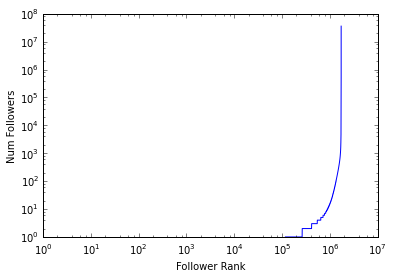

In [3]:
# Now, we'll plot the list to gain some intuition about the curve.
import matplotlib.pyplot as plt
plt.loglog(timoreilly_followers_counts)
plt.ylabel("Num Followers")
plt.xlabel("Follower Rank")

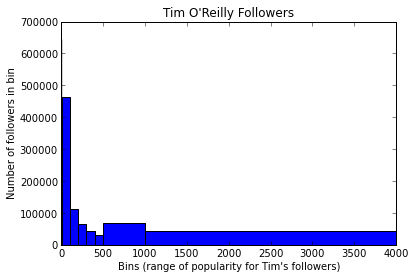

In [4]:
bins = [0,5,10,100,200,300,400,500,1000,4000]
plt.hist(timoreilly_followers_counts[:len(timoreilly_followers_counts)/100*99], bins=bins)


plt.title("Tim O'Reilly Followers")
plt.xlabel('Bins (range of popularity for Tim\'s followers)')
plt.ylabel('Number of followers in bin')

In [5]:
# We'll have a max of 10 followers to seem like bots or non-influencers.

MIN = 10
timoreilly_suspect_followers = [f 
                                for f in load_from_mongo('timoreilly', 'followers_profiles', 
                                                          projection={'followers_count' : 1, 'id' : 1, '_id' : 0})
                                if f['followers_count'] < MIN]

print "Tim O'Reilly has {0} 'suspect' followers for MIN={1}".format(len(timoreilly_suspect_followers), MIN)

Tim O'Reilly has 877457 'suspect' followers for MIN=10


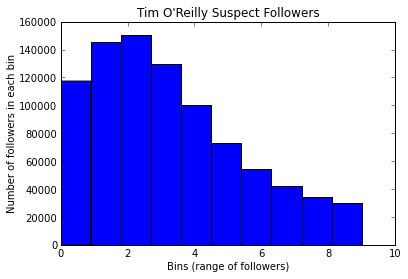

In [6]:
# This is a plot for 'suspect' followers.

timoreilly_suspect_followers_counts = sorted([f['followers_count'] 
                                              for f in timoreilly_suspect_followers], reverse=True)

plt.hist(timoreilly_suspect_followers_counts)
plt.title("Tim O'Reilly Suspect Followers")
plt.xlabel('Bins (range of followers)')
plt.ylabel('Number of followers in each bin')

Interesting. So *most* of the suspect followers appear to have 5 or fewer followers, so *MIN=5* might be a threshold to keep in mind. Let's gain a little more insight by calculating accumulation of these suspect followers for follower counts in the range of 1 to 5.

In [7]:
# A little more analysis of how the distribution breaks down
print "{0} of Tim O'Reilly's followers have 0 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 1]))

print "{0} of Tim O'Reilly's followers have 1 follower"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c <= 1]))

print "{0} of Tim O'Reilly's followers have less than 3 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 3]))

print "{0} of Tim O'Reilly's followers have less than 4 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 4]))

print "{0} of Tim O'Reilly's followers have less than 5 followers"\
.format(sum([1 for c in timoreilly_suspect_followers_counts if c < 5]))

117370 of Tim O'Reilly's followers have 0 followers
262417 of Tim O'Reilly's followers have 1 follower
412973 of Tim O'Reilly's followers have less than 3 followers
542748 of Tim O'Reilly's followers have less than 4 followers
643068 of Tim O'Reilly's followers have less than 5 followers


## What do Tim O'Reilly and Lady Gaga have in common?

In [8]:
timoreilly_followers_ids = set([fid
                 for ids in load_from_mongo('timoreilly', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

ladygaga_followers_ids = set([fid
                 for ids in load_from_mongo('ladygaga', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

# We'll calculate the number of followers in common between each celebrity
# by using set intersections.

timoreilly_ladygaga_common_followers_ids = timoreilly_followers_ids & ladygaga_followers_ids

print "Tim O'Reilly and Lady Gaga have {0} followers in common."\
.format(len(timoreilly_ladygaga_common_followers_ids))

Tim O'Reilly and Lady Gaga have 261450 followers in common.


### How many suspect followers in Tim O'Reilly's set of followers are in common with Lady Gaga's set?

In [9]:
timoreilly_suspect_followers_ids = set([f['id'] for f in timoreilly_suspect_followers])

print "{0} of Tim O'Reilly's 'suspect' followers are from the set that's in common with Lady Gaga's followers"\
.format(len(timoreilly_suspect_followers_ids & timoreilly_ladygaga_common_followers_ids))

38575 of Tim O'Reilly's 'suspect' followers are from the set that's in common with Lady Gaga's followers


## Jaccard Similarity

In [10]:
def jaccard(x,y): return 1.0*len(x & y) / len(x | y)

timoreilly_ladygaga_jaccard = jaccard(timoreilly_followers_ids, ladygaga_followers_ids)
print "Tim O'Reilly and Lady Gaga's Jaccard Index: {0}".format(timoreilly_ladygaga_jaccard)

# Need to define this variable, assuming you've pulled down the data for this account

marissamayer_followers_ids = set([fid
                 for ids in load_from_mongo('marissamayer', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

marissamayer_ladygaga_jaccard = jaccard(marissamayer_followers_ids, ladygaga_followers_ids)
print "Marissa Mayer and Lady Gaga's Jaccard Index: {0}".format(marissamayer_ladygaga_jaccard)

timoreilly_marissamayer_jaccard = jaccard(timoreilly_followers_ids, marissamayer_followers_ids)
print "Tim O'Reilly and Marissa Mayer's Jaccard Index {0}".format(timoreilly_marissamayer_jaccard)

Tim O'Reilly and Lady Gaga's Jaccard Index: 0.0062353871157
Marissa Mayer and Lady Gaga's Jaccard Index: 0.00202385195072
Tim O'Reilly and Marissa Mayer's Jaccard Index 0.0492571582527


In [21]:
timoreilly_followers_ids_not_suspect = timoreilly_followers_ids - timoreilly_suspect_followers_ids

timoreilly_ladygaga_jaccard_not_suspect = jaccard(timoreilly_followers_ids_not_suspect, ladygaga_followers_ids)
print "Tim O'Reilly and Lady Gaga's Jaccard Index adjusted for suspect followers: {0}"\
.format(timoreilly_ladygaga_jaccard_not_suspect)

# Need to define this variable, assuming you've pulled down the data for this account

marissamayer_followers_ids = set([fid
                 for ids in load_from_mongo('marissamayer', 'followers_ids', projection={'ids' : 1})
                     for fid in ids['ids']
                 ])

marissamayer_followers_ids_not_suspect = marissamayer_followers_ids - marissamayer_suspect_followers_ids

marissamayer_ladygaga_jaccard_not_suspect = jaccard(marissamayer_followers_ids_not_suspect, ladygaga_followers_ids)
print "Marissa Mayer and Lady Gaga's Jaccard Index adjusted for suspect followers: {0}"\
.format(marissamayer_ladygaga_jaccard_not_suspect)

timoreilly_marissamayer_jaccard_not_suspect = jaccard(timoreilly_followers_ids_not_suspect, marissamayer_followers_ids)
print "Tim O'Reilly and Marissa Mayer's Jaccard Index adjusted for suspect followers {0}"\
.format(timoreilly_marissamayer_jaccard_not_suspect)

Tim O'Reilly and Lady Gaga's Jaccard Index adjusted for suspect followers: 0.00542391691954
Marissa Mayer and Lady Gaga's Jaccard Index: 0.00177032283699
Tim O'Reilly and Marissa Mayer's Jaccard Index 0.0825309743004


## What do Tim O'Reilly, Lady Gaga, and Marissa Mayer all have in common?

In [32]:
# We'll calculate the number of followers in common between each person of interest
# by using set intersections.

all_common_followers_ids = marissamayer_followers_ids & timoreilly_followers_ids & ladygaga_followers_ids

print "Tim O'Reilly, Lady Gaga, and Marissa Mayer have {0} followers in common."\
.format(len(all_common_followers_ids))

Tim O'Reilly, Lady Gaga, and Marissa Mayer have 26307 followers in common.


Marissa Mayer has 69538 'suspect' followers for MIN=10


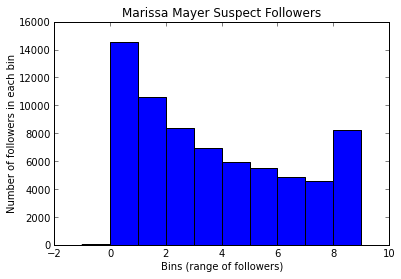

In [12]:
# Recycling code to get Marissa Mayer's suspect followers

MIN = 10
marissamayer_suspect_followers = [f 
                                for f in load_from_mongo('marissamayer', 'followers_profiles', 
                                                          projection={'followers_count' : 1, 'id' : 1, '_id' : 0})
                                if f['followers_count'] < MIN]

print "Marissa Mayer has {0} 'suspect' followers for MIN={1}".format(len(marissamayer_suspect_followers), MIN)

marissamayer_suspect_followers_counts = sorted([f['followers_count'] 
                                              for f in marissamayer_suspect_followers], reverse=True)

plt.hist(marissamayer_suspect_followers_counts)
plt.title("Marissa Mayer Suspect Followers")
plt.xlabel('Bins (range of followers)')
plt.ylabel('Number of followers in each bin')

In [29]:
marissamayer_suspect_followers_ids = set([f['id'] for f in marissamayer_suspect_followers])

all_common_followers_ids_not_suspect = all_common_followers_ids - \
                                       (timoreilly_suspect_followers_ids | marissamayer_suspect_followers_ids)

print "Tim O'Reilly, Lady Gaga, and Marissa Mayer have {0} non-suspect followers in common."\
.format(len(all_common_followers_ids_not_suspect))

Tim O'Reilly, Lady Gaga, and Marissa Mayer have 25470 non-suspect followers in common.


### How many of Marissa Mayer's followers follow Lady Gaga? 
### Also how many followers do Tim O'Reilly and Marrisa Mayer have in common?

In [34]:
marissamayer_ladygaga_followers_ids = marissamayer_followers_ids & ladygaga_followers_ids
marissamayer_ladygaga_followers_ids_not_suspect = marissamayer_ladygaga_followers_ids - marissamayer_suspect_followers_ids
                                                  

timoreilly_marissamayer_followers_ids = timoreilly_followers_ids & marissamayer_followers_ids
timoreilly_marissamayer_followers_ids_not_suspect = timoreilly_marissamayer_followers_ids - marissamayer_suspect_followers_ids
                                                    

print "Marissa Mayer and Lady Gaga have {0} followers in common. {1} of them are not suspect."\
.format(len(marissamayer_ladygaga_followers_ids), len(marissamayer_ladygaga_followers_ids_not_suspect))    
    
print "Tim O'Reilly and Marissa Mayer have {0} followers in common. {1} of them are not suspect."\
.format(len(timoreilly_marissamayer_followers_ids), len(timoreilly_marissamayer_followers_ids_not_suspect))

Marissa Mayer and Lady Gaga have 82553 followers in common. 72107 of them are not suspect.
Tim O'Reilly and Marissa Mayer have 99457 followers in common. 94612 of them are not suspect.
